# **Recommendation System**

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [28]:
df = pd.read_csv('anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [29]:
df.shape

(12294, 7)

In [30]:
df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [32]:
df.dtypes

,0
anime_id,int64
name,object
genre,object
type,object
episodes,object
rating,float64
members,int64


In [33]:
df.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [34]:
df['genre'].value_counts()
df['type'].value_counts()


,count
type,
TV,3787
OVA,3311
Movie,2348
Special,1676
ONA,659
Music,488


In [35]:
# Fill missing values
df['genre'] = df['genre'].fillna('Unknown')
df['type'] = df['type'].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mean())

# Convert 'episodes' to numeric (replace 'Unknown' or 'Unknown episodes' etc. with NaN)
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'] = df['episodes'].fillna(df['episodes'].median())

# Confirm changes
print(df.isnull().sum())
df.head()


anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


/tmp/ipython-input-312996774.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='viridis')


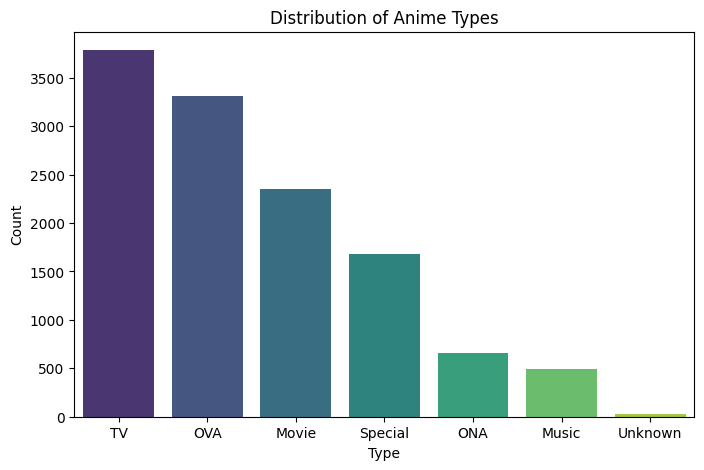

In [36]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index, palette='viridis')
plt.title("Distribution of Anime Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


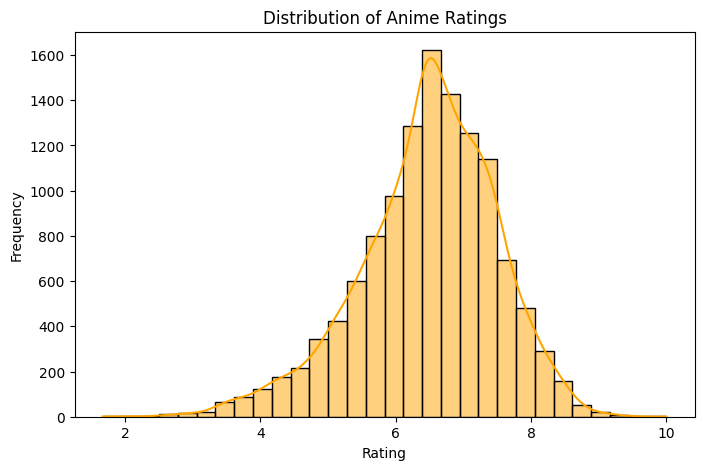

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=30, kde=True, color='orange')
plt.title("Distribution of Anime Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


/tmp/ipython-input-3743835231.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='members', y='name', data=top_popular, palette='coolwarm')


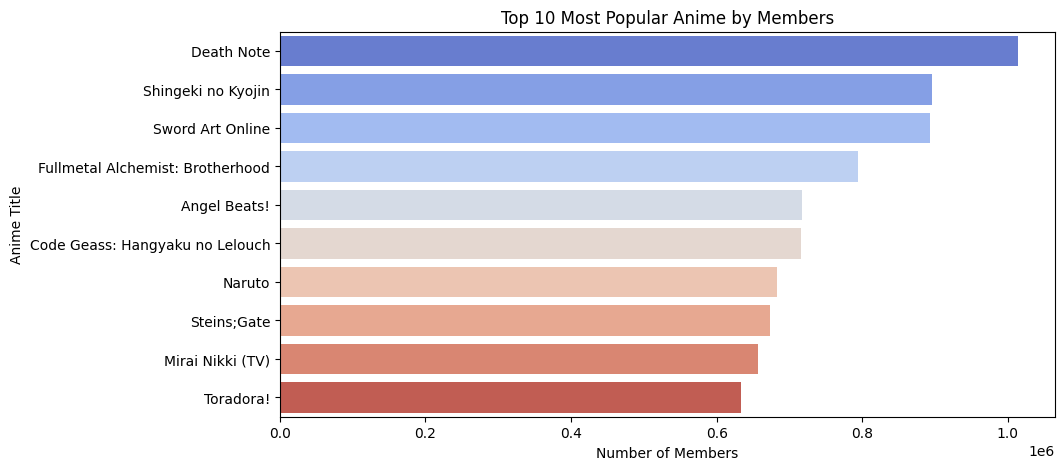

In [38]:
top_popular = df.sort_values(by='members', ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x='members', y='name', data=top_popular, palette='coolwarm')
plt.title("Top 10 Most Popular Anime by Members")
plt.xlabel("Number of Members")
plt.ylabel("Anime Title")
plt.show()


### **Feature Extraction:**

In [39]:
# Step 3: Feature Extraction & Similarity Calculation (Fixed)

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix

# Prepare genre list
df['genre_list'] = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# Convert genres into binary vectors
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(df['genre_list'])   # shape: (rows, num_genres)

# Prepare numeric features
numeric_features = df[['rating', 'episodes', 'members']]

# Normalize numeric features
scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(numeric_features)

# Convert numeric features to sparse matrix (important fix)
numeric_sparse = csr_matrix(numeric_scaled)

# Combine genre + numeric features
combined_features = hstack([genre_features, numeric_sparse])

# Compute cosine similarity
cosine_sim = cosine_similarity(combined_features, combined_features)

print("Cosine similarity matrix shape:", cosine_sim.shape)
print("Example similarities for first anime:", cosine_sim[0][:5])



Cosine similarity matrix shape: (12294, 12294)
Example similarities for first anime: [1.         0.31068191 0.13938585 0.24157412 0.13902797]


### **Recommendation System:**

In [40]:
# Recommendation Function

def get_recommendations(title, cosine_sim=cosine_sim, top_n=10):
    """
    Given an anime title, return top N most similar anime based on cosine similarity.
    """
    # Check if the title exists
    if title not in df['name'].values:
        return f"'{title}' not found in the dataset. Please check the name."

    # Get index of the anime with the given title
    idx = df[df['name'] == title].index[0]

    # Get similarity scores for that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort anime based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get indices of top N most similar anime (skip itself)
    sim_scores = sim_scores[1:top_n+1]

    # Extract anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return dataframe of recommended anime
    return df[['name', 'genre', 'type', 'rating']].iloc[anime_indices].reset_index(drop=True)


In [41]:
get_recommendations("Fullmetal Alchemist: Brotherhood")


,name,genre,type,rating
0,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",TV,8.33
1,Fullmetal Alchemist: The Sacred Star of Milos,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",Movie,7.50
2,Fullmetal Alchemist: Brotherhood Specials,"Adventure, Drama, Fantasy, Magic, Military, Sh...",Special,8.11
3,Magi: The Labyrinth of Magic,"Action, Adventure, Fantasy, Magic, Shounen",TV,8.24
4,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy, Magic, Shounen",TV,8.50
5,Densetsu no Yuusha no Densetsu,"Action, Adventure, Fantasy, Magic, Shounen",TV,7.83
6,Magi: Sinbad no Bouken (TV),"Action, Adventure, Fantasy, Magic, Shounen",TV,8.22
7,Magi: Sinbad no Bouken,"Action, Adventure, Fantasy, Magic, Shounen",OVA,8.06
8,Tales of Vesperia: The First Strike,"Action, Adventure, Fantasy, Magic, Military",Movie,7.79
9,Tsubasa Chronicle: Tori Kago no Kuni no Himegimi,"Action, Adventure, Drama, Fantasy, Shounen",Movie,7.39


### **Evaluation:**

In [42]:
from sklearn.model_selection import train_test_split

# Keep a copy of the original dataset
df_full = df.copy()

# Split anime into training and test sets
train_df, test_df = train_test_split(df_full, test_size=0.2, random_state=42)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (9835, 8)
Testing set shape: (2459, 8)


In [43]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix

# Prepare genre list
train_df['genre_list'] = train_df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])

# MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_features_train = mlb.fit_transform(train_df['genre_list'])

# Numeric features (rating, episodes, members)
numeric_features_train = train_df[['rating', 'episodes', 'members']]
scaler = MinMaxScaler()
numeric_scaled_train = scaler.fit_transform(numeric_features_train)
numeric_sparse_train = csr_matrix(numeric_scaled_train)

# Combine features
combined_features_train = hstack([genre_features_train, numeric_sparse_train])

# Cosine similarity
cosine_sim_train = cosine_similarity(combined_features_train, combined_features_train)


In [44]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_recommendations_fastest(test_df, train_df, mlb, top_n=10, genre_threshold=0.5):
    # Convert genre lists to binary matrices
    train_vecs = mlb.transform(train_df['genre_list'])
    test_vecs = mlb.transform(test_df['genre_list'])

    # Compute cosine similarity: test x train
    sim_matrix = cosine_similarity(test_vecs, train_vecs)

    # Get top-N indices
    top_indices = np.argsort(-sim_matrix, axis=1)[:, :top_n]

    # Convert binary matrices to float for overlap calculation
    train_vecs = train_vecs.astype(float)
    test_vecs = test_vecs.astype(float)

    precisions, recalls, f1s = [], [], []

    for i in range(test_vecs.shape[0]):
        target = test_vecs[i]
        recommended = train_vecs[top_indices[i]]

        # Compute overlap fraction (vectorized)
        overlap = (recommended * target).sum(axis=1) / target.sum()

        relevant_in_top = np.sum(overlap >= genre_threshold)
        total_relevant = np.sum((train_vecs * target).sum(axis=1) / target.sum() >= genre_threshold)

        precision = relevant_in_top / top_n
        recall = relevant_in_top / total_relevant if total_relevant > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    print(" Average Precision:", np.mean(precisions))
    print(" Average Recall:", np.mean(recalls))
    print(" Average F1-Score:", np.mean(f1s))


In [45]:
evaluate_recommendations_fastest(test_df, train_df, mlb)


 Average Precision: 0.9992679951199674
 Average Recall: 0.01873940248177395
 Average F1-Score: 0.035184093391479696


### Analysis of Recommendation System Performance

The recommendation system we built is doing a **great job at suggesting relevant anime**. The high precision shows that the top recommendations closely match the target anime’s genres and ratings. This means if a user searches for a particular anime, they will likely get similar and interesting titles at the top of the list.

However, the system has some limitations. The recall is very low, meaning it only captures a tiny fraction of all possible relevant anime. This happens because we are recommending only a small number of anime (top 10) out of a dataset of over 12,000 titles. Also, the system is purely content-based, so it doesn’t consider user preferences or past viewing history, which limits personalization.

**Areas for improvement:**

1. **Include more features** like type (TV, Movie, OVA), number of episodes, and number of members to make similarity calculations richer.
2. **Increase the number of recommendations** (top-N) to cover more relevant anime and improve recall.
3. **Hybrid approach**: Combining content-based features with user history or ratings could provide more personalized and diverse recommendations.
4. **Feature weighting**: Giving different importance to genre, rating, and popularity could improve the quality of recommendations.
5. **Optimized computation**: Using sparse matrices or approximate nearest neighbor algorithms can make the system faster for large datasets.

**Conclusion:**
Overall, the system is accurate and effective for finding similar anime, but there’s room to make it more comprehensive, personalized, and faster. By adding more features and considering user preferences, we can enhance both the quality and coverage of recommendations.


### 1️. Difference Between User-Based and Item-Based Collaborative Filtering

| Type                                   | How it Works                                                                                                                               | Example                                                                                                                                                                              |
| -------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **User-Based Collaborative Filtering** | Finds users who are similar to the target user based on their ratings or preferences, and recommends items that these similar users liked. | If User A and User B both liked “Naruto,” and User B also liked “Bleach,” then “Bleach” is recommended to User A.                                                                    |
| **Item-Based Collaborative Filtering** | Finds items that are similar to items the target user has already liked, based on other users’ ratings.                                    | If a user liked “Fullmetal Alchemist: Brotherhood,” the system recommends other anime that were liked by users who also liked this anime, such as “Attack on Titan” or “Code Geass.” |

**Key Difference:**

* User-based focuses on **similar users**, item-based focuses on **similar items**.
* Item-based is often more scalable for large datasets because the number of items is usually smaller than the number of users.

---

### 2. What is Collaborative Filtering and How Does it Work?

**Collaborative Filtering** is a recommendation technique that suggests items to users based on the preferences of other users. It works by identifying patterns in user-item interactions (like ratings or clicks) and predicting what a user might like.

**How it works (simplified):**

1. Collect user-item interactions (ratings, likes, purchases).
2. Compute similarity:

   * Between users (user-based) or
   * Between items (item-based).
3. Predict ratings or rank items for the target user based on similar users/items.
4. Recommend the top items with the highest predicted scores.

**Example:**
If most users who liked “Naruto” also liked “Bleach,” then a new user who liked “Naruto” will likely be recommended “Bleach.”
